In [1]:
%pip install numpy matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 935.1 kB/s eta 0:00:0000:0100:02
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 1.7 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.5 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


(programming) Design and conduct an experiment to demonstrate the
diffculties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q*(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, alpha = 0.1. Use
epsilon = 0.1 and longer runs, say of 10,000 steps.

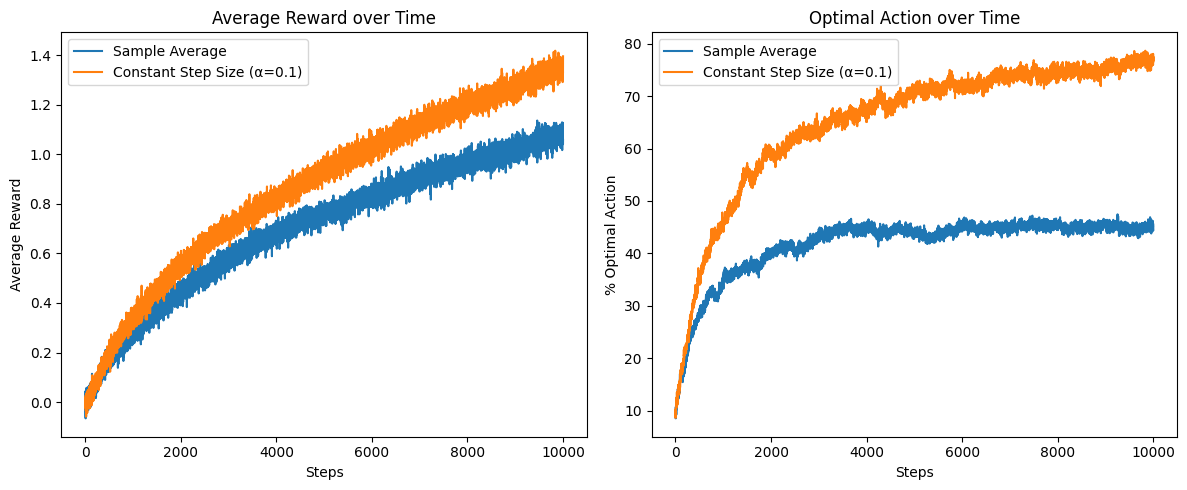

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Bandit class for nonstationary problem
class NonstationaryBandit:
    def __init__(self, k=10, std_walk=0.01):
        self.k = k
        self.q_true = np.zeros(k)  # all q*(a) start equal
        self.std_walk = std_walk

    def step(self):
        # Random walk for q*(a)
        self.q_true += np.random.normal(0, self.std_walk, self.k)

    def get_reward(self, action):
        # Return reward with noise
        return np.random.normal(self.q_true[action], 1.0)

    def optimal_action(self):
        return np.argmax(self.q_true)

# Agent class with two update strategies
class Agent:
    def __init__(self, k=10, epsilon=0.1, alpha=None):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha  # If None, use sample-average
        self.q_est = np.zeros(k)
        self.action_counts = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.q_est)

    def update(self, action, reward):
        self.action_counts[action] += 1
        if self.alpha is None:
            # Sample-average
            step_size = 1.0 / self.action_counts[action]
        else:
            # Constant step-size
            step_size = self.alpha
        self.q_est[action] += step_size * (reward - self.q_est[action])

def run_experiment(runs=2000, steps=10000, epsilon=0.1, alpha=0.1):
    avg_rewards_sa = np.zeros(steps)
    opt_actions_sa = np.zeros(steps)
    avg_rewards_cs = np.zeros(steps)
    opt_actions_cs = np.zeros(steps)

    for _ in range(runs):
        bandit = NonstationaryBandit()
        agent_sa = Agent(epsilon=epsilon, alpha=None)
        agent_cs = Agent(epsilon=epsilon, alpha=alpha)

        for t in range(steps):
            bandit.step()
            optimal = bandit.optimal_action()

            # Sample-average
            a_sa = agent_sa.select_action()
            r_sa = bandit.get_reward(a_sa)
            agent_sa.update(a_sa, r_sa)
            avg_rewards_sa[t] += r_sa
            opt_actions_sa[t] += (a_sa == optimal)

            # Constant step-size
            a_cs = agent_cs.select_action()
            r_cs = bandit.get_reward(a_cs)
            agent_cs.update(a_cs, r_cs)
            avg_rewards_cs[t] += r_cs
            opt_actions_cs[t] += (a_cs == optimal)

    # Averaging over runs
    avg_rewards_sa /= runs
    opt_actions_sa = (opt_actions_sa / runs) * 100
    avg_rewards_cs /= runs
    opt_actions_cs = (opt_actions_cs / runs) * 100

    return avg_rewards_sa, opt_actions_sa, avg_rewards_cs, opt_actions_cs

# Run experiment
avg_r_sa, opt_sa, avg_r_cs, opt_cs = run_experiment()

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_r_sa, label="Sample Average")
plt.plot(avg_r_cs, label="Constant Step Size (α=0.1)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(opt_sa, label="Sample Average")
plt.plot(opt_cs, label="Constant Step Size (α=0.1)")
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.title("Optimal Action over Time")
plt.legend()

plt.tight_layout()
plt.show()
